In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

In [3]:
better_shots_df = pd.read_csv("data/shot_logs.csv")

In [4]:
class MakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values,dtype=torch.float32)
        self.labels = torch.tensor(labels.values,dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [14]:
def shots_data_processing(df):
    #select columns, label encoding
    df_condensed = df[["LOCATION","W","FINAL_MARGIN","SHOT_NUMBER","PERIOD","SHOT_CLOCK","DRIBBLES","TOUCH_TIME","SHOT_DIST","PTS_TYPE","CLOSE_DEF_DIST"]]
    df_outcome = df["FGM"]
    df_condensed.loc[:,"LOCATION"] = df["LOCATION"] == 'H'
    df_condensed.loc[:,"W"] = df["W"] == 'W'
    df_condensed[["LOCATION","W"]] = df_condensed[["LOCATION","W"]].astype(int)

    #scaling to [-1,1]
    def scaling_func(x):
        if not (x.max() == 1 and x.min() == 0):
            return 2 * (x - x.min()) / (x.max() - x.min()) - 1
        return x
    df_condensed_scaled = df_condensed.apply(scaling_func).astype("float32")

    df_condensed_scaled = df_condensed_scaled.fillna(0)

    return MakeDataset(df_condensed_scaled,df_outcome)

In [15]:
train_data = better_shots_df.sample(frac=0.9)
dev_data = better_shots_df.drop(train_data.index).sample(frac=0.5)
test_data = better_shots_df.drop(pd.concat([train_data,dev_data]).index)

processed_train_data = shots_data_processing(train_data)
processed_dev_data = shots_data_processing(dev_data)
processed_test_data = shots_data_processing(test_data)

batch_size = 32

trainloader = DataLoader(processed_train_data,batch_size=batch_size,shuffle=False)
devloader = DataLoader(processed_dev_data,batch_size=batch_size,shuffle=False)
testloader = DataLoader(processed_test_data,batch_size=batch_size,shuffle=False)

/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_33280/4107275900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed[["LOCATION","W"]] = df_condensed[["LOCATION","W"]].astype(int)
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_33280/4107275900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed[["LOCATION","W"]] = df_condensed[["LOCATION","W"]].astype(int)
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_33280/4107275900.py:7: SettingWithCopyWarning

In [16]:
class Model(nn.Module):
    def __init__(self,input_size,num_hidden_layers=50):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(input_size,num_hidden_layers)
        self.fc2 = nn.Linear(num_hidden_layers,1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self._initialize_weights()
    def forward(self,x):
        f1 = self.relu(self.fc1(x))
        f2 = self.fc2(f1)
        return f2
    def _initialize_weights(self):
        # Apply He initialization to all layers with ReLU/LeakyReLU activations
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')

        # Bias initialization (optional but recommended)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

In [17]:
model = Model(processed_train_data[0][0].shape[0],12)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 3
loss_values = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print statistics
        if i % 1000 == 999:    # print every n mini-batches
            loss_values.append(running_loss/1000)
            running_loss = 0.0

print('Finished Training')

3602it [00:01, 2882.39it/s]
3602it [00:01, 2702.78it/s]
3602it [00:01, 2907.75it/s]

Finished Training


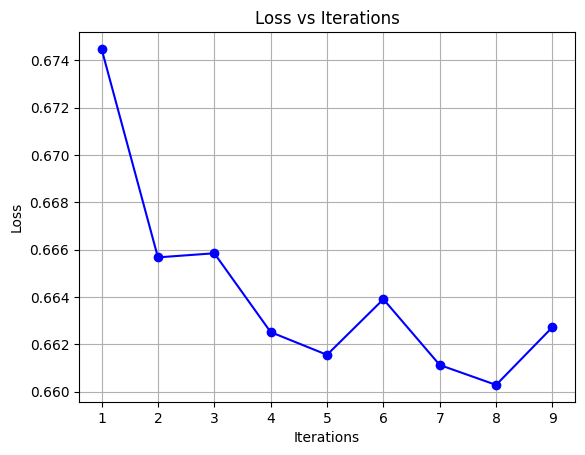

In [19]:
# Plotting the loss
# plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.plot(range(1, (len(trainloader)//1000)*num_epochs+1), loss_values, marker='o', color='b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.grid(True)
plt.show()

In [20]:
correct, total = 0, 0
with torch.no_grad():
    for data in devloader:
        features, outcome = data
        outputs = model(features)  # Raw logits
        predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
        total += outcome.size(0)
        correct += (predicted == outcome).sum().item()
    print(correct / total)  # Accuracy

0.5576202373516552


In [21]:
correct, total = 0, 0
with torch.no_grad():
    for data in testloader:
        features, outcome = data
        outputs = model(features)  # Raw logits
        predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
        total += outcome.size(0)
        correct += (predicted == outcome).sum().item()
    print(correct / total)  # Accuracy

0.5648914571294705
